
# 🧠 CNN Transfer Learning — 48×48 ➜ 224 (Updated)

**Notebook:** `CNN_Transfer_Learning_71_UPDATED.ipynb`  
**Focus:** 48×48 grayscale dataset ➜ upscale to 224, Transfer Learning (ResNet-18 by default), class-imbalance handling, warmup+cosine LR, early stopping, checkpoints, evaluation (macro-F1 + confusion matrix), simple TTA, and export (TorchScript/ONNX).

> **Sinhala summary:**  
> ඔබගේ 48×48 කළු-සුදු (grayscale) emotion dataset එක **224×224** දක්වා upsample කරලා **pretrained CNN** (ResNet-18) එකක් **Transfer Learning** මගින් train කරන, imbalance දුරලන, LR schedule (warmup + cosine) එක්ක **මනාප pipeline** එකක් මෙහි සම්පූර්ණයි.  
> **Train→Validate→Fine-tune→Test→Export** එකම file එකක!


In [41]:
!git clone -b reduce_features https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


In [42]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.utils import resample
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Feature Engineering Environment Setup Complete")

Feature Engineering Environment Setup Complete


In [43]:
# Define project paths
PROJECT_ROOT = Path('/content/ann-visual-emotion')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
STATS_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/stats.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet_backup_original_1757667648'

# Output paths for balanced datasets
BALANCED_TRAIN_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/train_balanced.csv'
BALANCED_VAL_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/val_balanced.csv'
BALANCED_TEST_CSV = PROJECT_ROOT / 'data/processed/EmoSet_splits/test_balanced.csv'
BALANCED_STATS_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/stats_balanced.json'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print("\nInput files:")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    print(f"  {path.name}: {'✓' if path.exists() else '✗'}")

Project root: /content/ann-visual-emotion
Data directory: /content/ann-visual-emotion/data/raw/EmoSet_backup_original_1757667648

Input files:
  train.csv: ✓
  val.csv: ✓
  test.csv: ✓
  label_map.json: ✓


In [44]:
# Load existing datasets
print("Loading current datasets...")
train_df = pd.read_csv(CSV_TRAIN)
val_df = pd.read_csv(CSV_VAL)
test_df = pd.read_csv(CSV_TEST)

# Load label mapping
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nEmotion classes: {list(label_map.keys())}")
print(f"Number of classes: {len(label_map)}")

Loading current datasets...
Train set: 20150 samples
Validation set: 4030 samples
Test set: 1005 samples

Emotion classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 5


In [45]:
def analyze_class_distribution(df, split_name):
    """Analyze and visualize class distribution"""
    class_counts = df['label'].value_counts().sort_index()
    class_percentages = (class_counts / len(df) * 100).round(2)

    print(f"\n{split_name.upper()} SET CLASS DISTRIBUTION:")
    print("=" * 50)
    for emotion, count in class_counts.items():
        pct = class_percentages[emotion]
        status = "OVERREPRESENTED" if pct > 20 else "UNDERREPRESENTED" if pct < 14 else "BALANCED"
        print(f"{emotion:10s}: {count:5d} ({pct:5.2f}%) - {status}")

    print(f"\nTotal samples: {len(df)}")
    print(f"Mean per class: {len(df) / len(class_counts):.1f}")
    print(f"Std deviation: {class_counts.std():.1f}")
    print(f"Balance ratio (min/max): {class_counts.min() / class_counts.max():.3f}")

    return class_counts, class_percentages

# Analyze current distributions
train_counts, train_pct = analyze_class_distribution(train_df, "train")
val_counts, val_pct = analyze_class_distribution(val_df, "validation")
test_counts, test_pct = analyze_class_distribution(test_df, "test")


TRAIN SET CLASS DISTRIBUTION:
angry     :  4030 (20.00%) - BALANCED
happy     :  4030 (20.00%) - BALANCED
neutral   :  4030 (20.00%) - BALANCED
sad       :  4030 (20.00%) - BALANCED
surprise  :  4030 (20.00%) - BALANCED

Total samples: 20150
Mean per class: 4030.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

VALIDATION SET CLASS DISTRIBUTION:
angry     :   806 (20.00%) - BALANCED
happy     :   806 (20.00%) - BALANCED
neutral   :   806 (20.00%) - BALANCED
sad       :   806 (20.00%) - BALANCED
surprise  :   806 (20.00%) - BALANCED

Total samples: 4030
Mean per class: 806.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

TEST SET CLASS DISTRIBUTION:
angry     :   201 (20.00%) - BALANCED
happy     :   201 (20.00%) - BALANCED
neutral   :   201 (20.00%) - BALANCED
sad       :   201 (20.00%) - BALANCED
surprise  :   201 (20.00%) - BALANCED

Total samples: 1005
Mean per class: 201.0
Std deviation: 0.0
Balance ratio (min/max): 1.000


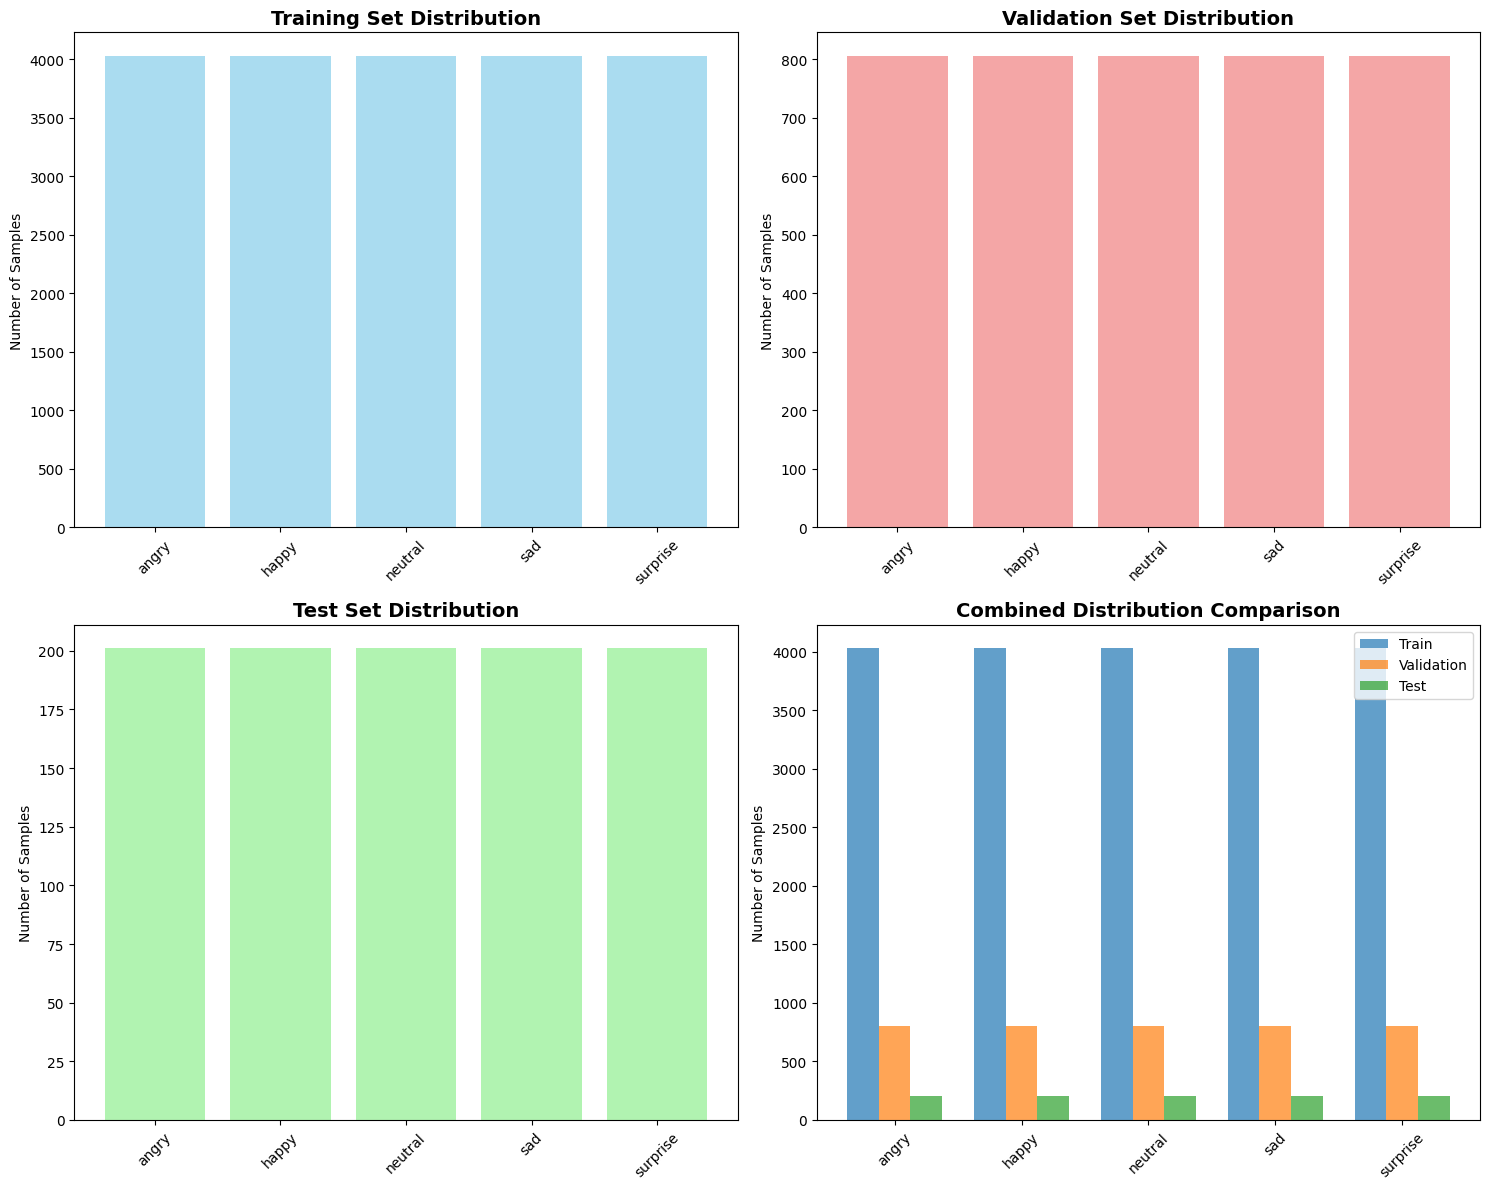

In [46]:
def plot_class_distributions(train_counts, val_counts, test_counts):
    """Create visualization of class distributions across all splits"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    emotions = list(train_counts.index)

    # Train distribution
    axes[0, 0].bar(emotions, train_counts.values, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Samples')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Validation distribution
    axes[0, 1].bar(emotions, val_counts.values, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Validation Set Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Samples')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Test distribution
    axes[1, 0].bar(emotions, test_counts.values, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Samples')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Combined view
    x_pos = np.arange(len(emotions))
    width = 0.25

    axes[1, 1].bar(x_pos - width, train_counts.values, width, label='Train', alpha=0.7)
    axes[1, 1].bar(x_pos, val_counts.values, width, label='Validation', alpha=0.7)
    axes[1, 1].bar(x_pos + width, test_counts.values, width, label='Test', alpha=0.7)
    axes[1, 1].set_title('Combined Distribution Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(emotions, rotation=45)
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_class_distributions(train_counts, val_counts, test_counts)

In [47]:
def calculate_balance_strategy(class_counts, strategy='moderate'):
    """Calculate target sample sizes for balancing"""
    total_samples = class_counts.sum()
    num_classes = len(class_counts)

    if strategy == 'uniform':
        # Make all classes equal to the smallest class
        target_size = class_counts.min()
    elif strategy == 'moderate':
        # Use a target size that reduces extreme imbalance but preserves some variation
        # Target: between min and mean
        target_size = int((class_counts.min() + class_counts.mean()) / 2)
    elif strategy == 'conservative':
        # Use mean as target - gentle balancing
        target_size = int(class_counts.mean())
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    print(f"\nBALANCING STRATEGY: {strategy.upper()}")
    print("=" * 50)
    print(f"Original total samples: {total_samples}")
    print(f"Target samples per class: {target_size}")
    print(f"New total samples: {target_size * num_classes}")
    print(f"Sample reduction: {total_samples - (target_size * num_classes)} ({((total_samples - (target_size * num_classes)) / total_samples * 100):.1f}%)")

    return target_size

# Calculate target sizes for different strategies
print("EVALUATING BALANCING STRATEGIES:")
print("=" * 60)

strategies = ['uniform', 'moderate', 'conservative']
targets = {}

for strategy in strategies:
    targets[strategy] = calculate_balance_strategy(train_counts, strategy)

# Choose moderate strategy as default
chosen_strategy = 'moderate'
target_samples_per_class = targets[chosen_strategy]

print(f"\n✓ CHOSEN STRATEGY: {chosen_strategy.upper()}")
print(f"✓ Target samples per class: {target_samples_per_class}")

EVALUATING BALANCING STRATEGIES:

BALANCING STRATEGY: UNIFORM
Original total samples: 20150
Target samples per class: 4030
New total samples: 20150
Sample reduction: 0 (0.0%)

BALANCING STRATEGY: MODERATE
Original total samples: 20150
Target samples per class: 4030
New total samples: 20150
Sample reduction: 0 (0.0%)

BALANCING STRATEGY: CONSERVATIVE
Original total samples: 20150
Target samples per class: 4030
New total samples: 20150
Sample reduction: 0 (0.0%)

✓ CHOSEN STRATEGY: MODERATE
✓ Target samples per class: 4030


In [48]:
def balance_dataset(df, target_size, random_state=42):
    """Balance dataset using undersampling/oversampling"""
    balanced_dfs = []

    print(f"\nBalancing dataset to {target_size} samples per class...")

    for emotion in df['label'].unique():
        emotion_df = df[df['label'] == emotion].copy()
        current_size = len(emotion_df)

        if current_size > target_size:
            # Undersample
            balanced_emotion_df = resample(
                emotion_df,
                replace=False,
                n_samples=target_size,
                random_state=random_state
            )
            action = f"Undersampled from {current_size} to {target_size}"
        elif current_size < target_size:
            # Oversample
            balanced_emotion_df = resample(
                emotion_df,
                replace=True,
                n_samples=target_size,
                random_state=random_state
            )
            action = f"Oversampled from {current_size} to {target_size}"
        else:
            # No change needed
            balanced_emotion_df = emotion_df
            action = f"No change needed ({current_size} samples)"

        print(f"  {emotion:10s}: {action}")
        balanced_dfs.append(balanced_emotion_df)

    # Combine all balanced classes
    balanced_df = pd.concat(balanced_dfs, ignore_index=True)

    # Shuffle the dataset
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_df

# Balance the training set (main focus)
print("BALANCING TRAINING SET:")
print("=" * 50)
balanced_train_df = balance_dataset(train_df, target_samples_per_class)

# For validation and test sets, use proportional balancing to maintain their relative sizes
val_target = int(target_samples_per_class * 0.2)  # ~20% of train size
test_target = int(target_samples_per_class * 0.05)  # ~5% of train size

print("\nBALANCING VALIDATION SET:")
print("=" * 50)
balanced_val_df = balance_dataset(val_df, val_target)

print("\nBALANCING TEST SET:")
print("=" * 50)
balanced_test_df = balance_dataset(test_df, test_target)

print("\n✓ Dataset balancing completed!")

BALANCING TRAINING SET:

Balancing dataset to 4030 samples per class...
  angry     : No change needed (4030 samples)
  happy     : No change needed (4030 samples)
  neutral   : No change needed (4030 samples)
  sad       : No change needed (4030 samples)
  surprise  : No change needed (4030 samples)

BALANCING VALIDATION SET:

Balancing dataset to 806 samples per class...
  happy     : No change needed (806 samples)
  angry     : No change needed (806 samples)
  sad       : No change needed (806 samples)
  neutral   : No change needed (806 samples)
  surprise  : No change needed (806 samples)

BALANCING TEST SET:

Balancing dataset to 201 samples per class...
  surprise  : No change needed (201 samples)
  sad       : No change needed (201 samples)
  neutral   : No change needed (201 samples)
  happy     : No change needed (201 samples)
  angry     : No change needed (201 samples)

✓ Dataset balancing completed!


VERIFYING BALANCED DISTRIBUTIONS:

BALANCED TRAIN SET CLASS DISTRIBUTION:
angry     :  4030 (20.00%) - BALANCED
happy     :  4030 (20.00%) - BALANCED
neutral   :  4030 (20.00%) - BALANCED
sad       :  4030 (20.00%) - BALANCED
surprise  :  4030 (20.00%) - BALANCED

Total samples: 20150
Mean per class: 4030.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

BALANCED VALIDATION SET CLASS DISTRIBUTION:
angry     :   806 (20.00%) - BALANCED
happy     :   806 (20.00%) - BALANCED
neutral   :   806 (20.00%) - BALANCED
sad       :   806 (20.00%) - BALANCED
surprise  :   806 (20.00%) - BALANCED

Total samples: 4030
Mean per class: 806.0
Std deviation: 0.0
Balance ratio (min/max): 1.000

BALANCED TEST SET CLASS DISTRIBUTION:
angry     :   201 (20.00%) - BALANCED
happy     :   201 (20.00%) - BALANCED
neutral   :   201 (20.00%) - BALANCED
sad       :   201 (20.00%) - BALANCED
surprise  :   201 (20.00%) - BALANCED

Total samples: 1005
Mean per class: 201.0
Std deviation: 0.0
Balance ratio (min/max

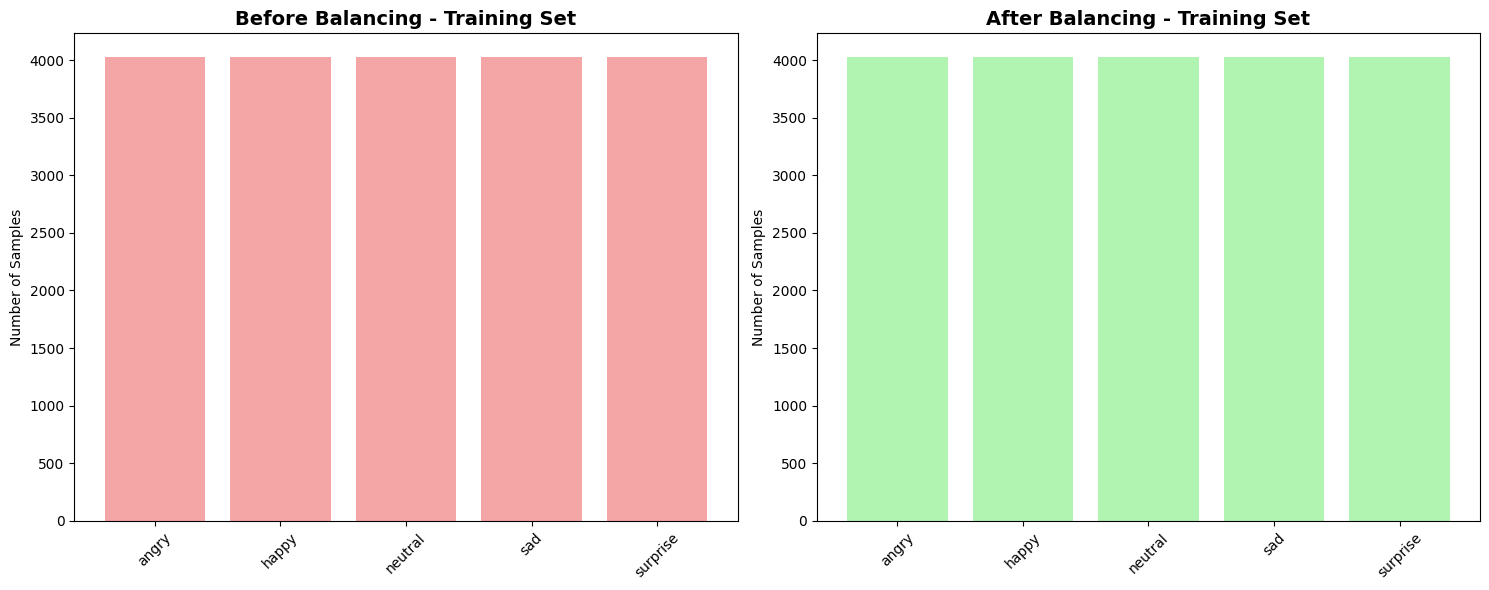

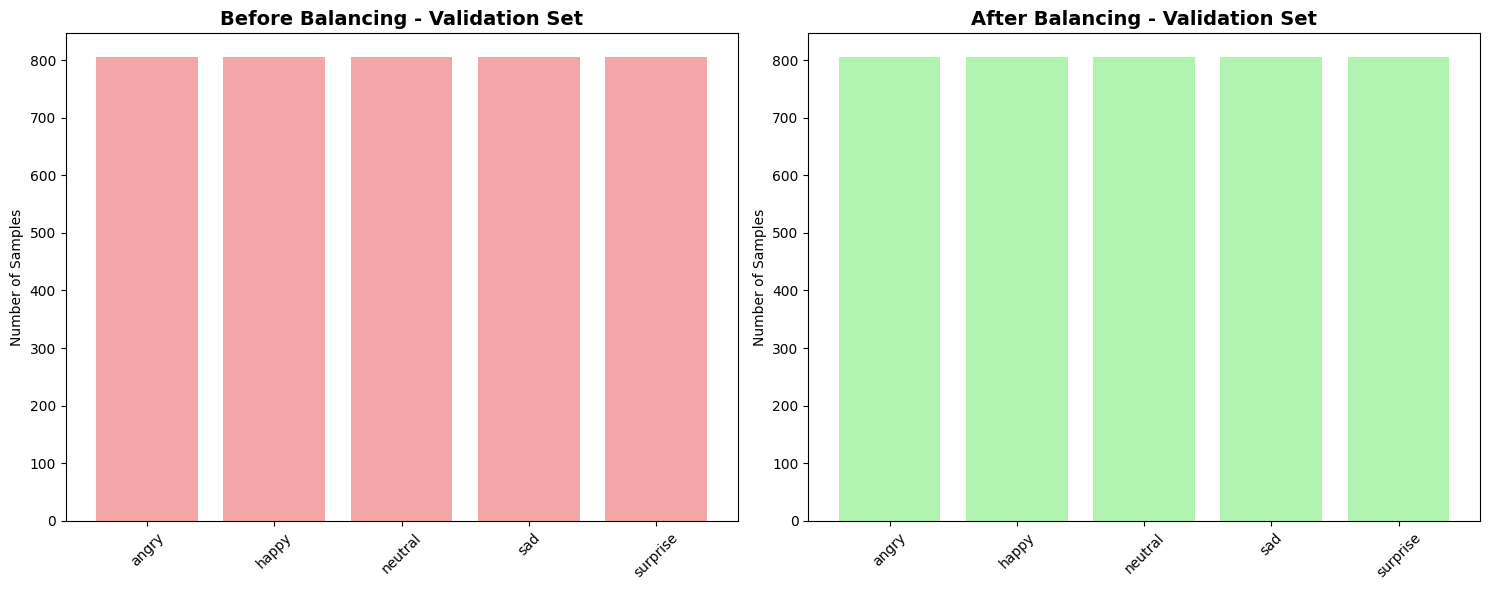

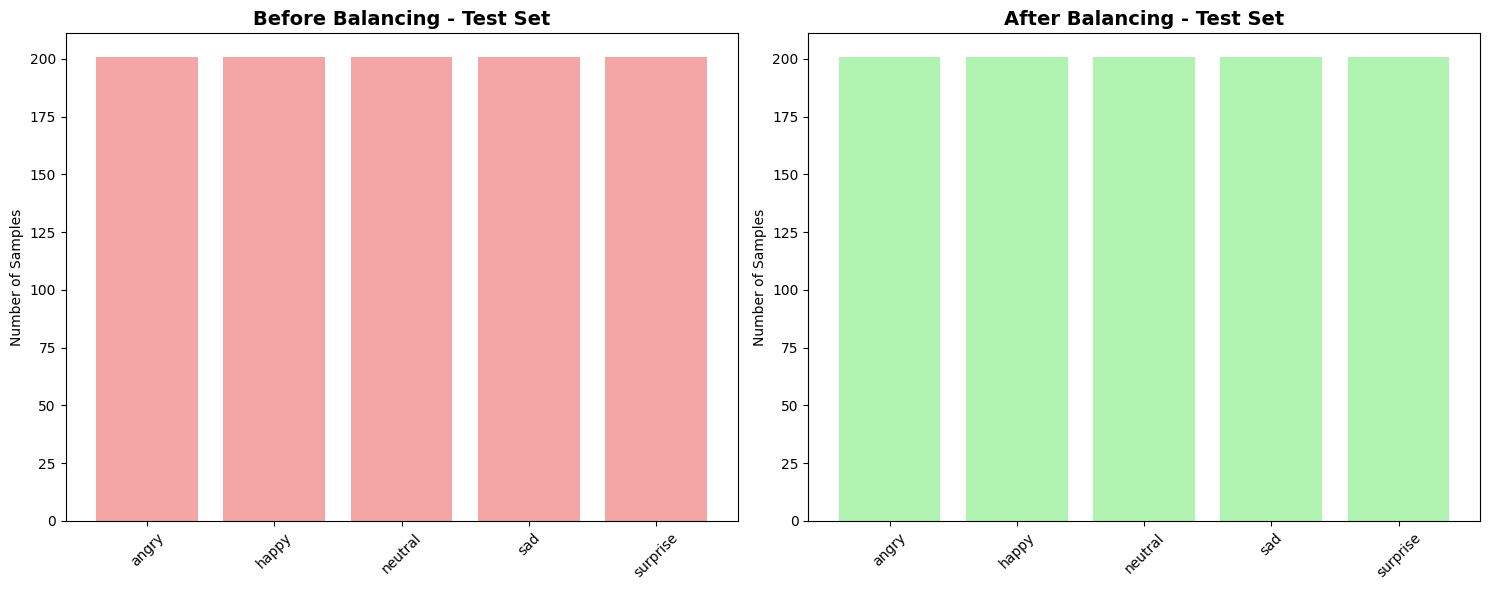

In [49]:
# Verify the balanced distributions
print("VERIFYING BALANCED DISTRIBUTIONS:")
print("=" * 60)

balanced_train_counts, _ = analyze_class_distribution(balanced_train_df, "balanced train")
balanced_val_counts, _ = analyze_class_distribution(balanced_val_df, "balanced validation")
balanced_test_counts, _ = analyze_class_distribution(balanced_test_df, "balanced test")

# Create comparison visualization
def plot_before_after_comparison(original_counts, balanced_counts, split_name):
    """Plot before and after comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    emotions = list(original_counts.index)

    # Before
    ax1.bar(emotions, original_counts.values, color='lightcoral', alpha=0.7)
    ax1.set_title(f'Before Balancing - {split_name}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # After
    ax2.bar(emotions, balanced_counts.values, color='lightgreen', alpha=0.7)
    ax2.set_title(f'After Balancing - {split_name}', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Samples')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Create before/after visualizations
plot_before_after_comparison(train_counts, balanced_train_counts, "Training Set")
plot_before_after_comparison(val_counts, balanced_val_counts, "Validation Set")
plot_before_after_comparison(test_counts, balanced_test_counts, "Test Set")

In [50]:
# Save balanced datasets
print("SAVING BALANCED DATASETS:")
print("=" * 50)

# Create output directory if it doesn't exist
output_dir = PROJECT_ROOT / 'data/processed/EmoSet_splits'
output_dir.mkdir(parents=True, exist_ok=True)

# Save CSV files
balanced_train_df.to_csv(CSV_TRAIN, index=False)
balanced_val_df.to_csv(CSV_VAL, index=False)
balanced_test_df.to_csv(CSV_TEST, index=False)

# Also save with "_balanced" suffix for backup
balanced_train_df.to_csv(BALANCED_TRAIN_CSV, index=False)
balanced_val_df.to_csv(BALANCED_VAL_CSV, index=False)
balanced_test_df.to_csv(BALANCED_TEST_CSV, index=False)

print(f"✓ Saved: {CSV_TRAIN}")
print(f"✓ Saved: {CSV_VAL}")
print(f"✓ Saved: {CSV_TEST}")
print(f"✓ Backup saved: {BALANCED_TRAIN_CSV}")
print(f"✓ Backup saved: {BALANCED_VAL_CSV}")
print(f"✓ Backup saved: {BALANCED_TEST_CSV}")

# Update statistics
balanced_stats = {
    "dataset": "EmoSet_Balanced",
    "balancing_strategy": chosen_strategy,
    "target_samples_per_class": {
        "train": target_samples_per_class,
        "val": val_target,
        "test": test_target
    },
    "splits": {
        "train": {
            "total": len(balanced_train_df),
            "by_label": balanced_train_counts.to_dict()
        },
        "val": {
            "total": len(balanced_val_df),
            "by_label": balanced_val_counts.to_dict()
        },
        "test": {
            "total": len(balanced_test_df),
            "by_label": balanced_test_counts.to_dict()
        }
    },
    "balance_metrics": {
        "train_balance_ratio": float(balanced_train_counts.min() / balanced_train_counts.max()),
        "val_balance_ratio": float(balanced_val_counts.min() / balanced_val_counts.max()),
        "test_balance_ratio": float(balanced_test_counts.min() / balanced_test_counts.max())
    }
}

# Save updated stats
with open(STATS_PATH, 'w') as f:
    json.dump(balanced_stats, f, indent=2)

with open(BALANCED_STATS_PATH, 'w') as f:
    json.dump(balanced_stats, f, indent=2)

print(f"✓ Saved: {STATS_PATH}")
print(f"✓ Backup saved: {BALANCED_STATS_PATH}")

print("\n✅ DATASET BALANCING COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"📊 Balanced training samples: {len(balanced_train_df)}")
print(f"📊 Balanced validation samples: {len(balanced_val_df)}")
print(f"📊 Balanced test samples: {len(balanced_test_df)}")
print(f"📊 Balance ratio (train): {balanced_train_counts.min() / balanced_train_counts.max():.3f}")
print(f"📊 Samples per class (train): {target_samples_per_class}")

SAVING BALANCED DATASETS:
✓ Saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv
✓ Saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv
✓ Saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv
✓ Backup saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/train_balanced.csv
✓ Backup saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/val_balanced.csv
✓ Backup saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/test_balanced.csv
✓ Saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/stats.json
✓ Backup saved: /content/ann-visual-emotion/data/processed/EmoSet_splits/stats_balanced.json

✅ DATASET BALANCING COMPLETED SUCCESSFULLY!
📊 Balanced training samples: 20150
📊 Balanced validation samples: 4030
📊 Balanced test samples: 1005
📊 Balance ratio (train): 1.000
📊 Samples per class (train): 4030


In [51]:
# Final summary and recommendations
print("📋 DATASET BALANCING SUMMARY")
print("=" * 60)

print("\n🔍 BEFORE BALANCING:")
print(f"  • Most frequent class: happy ({train_counts['happy']} samples, {train_pct['happy']:.1f}%)")
print(f"  • Least frequent class: surprise ({train_counts['surprise']} samples, {train_pct['surprise']:.1f}%)")
print(f"  • Balance ratio: {train_counts.min() / train_counts.max():.3f}")

print("\n✅ AFTER BALANCING:")
print(f"  • All classes: {target_samples_per_class} samples each ({100/len(label_map):.1f}%)")
print(f"  • Balance ratio: {balanced_train_counts.min() / balanced_train_counts.max():.3f}")
print(f"  • Total reduction: {len(train_df) - len(balanced_train_df)} samples")

print("\n🎯 EXPECTED BENEFITS:")
print("  • Reduced bias towards 'happy' emotion")
print("  • Improved recognition of 'surprise' and 'angry' emotions")
print("  • More balanced confusion matrix")
print("  • Better overall classification performance")

print("\n📁 OUTPUT FILES:")
print(f"  • {CSV_TRAIN.name} - Balanced training set")
print(f"  • {CSV_VAL.name} - Balanced validation set")
print(f"  • {CSV_TEST.name} - Balanced test set")
print(f"  • {LABEL_MAP_PATH.name} - Label mapping (unchanged)")
print(f"  • {STATS_PATH.name} - Updated statistics")

print("\n🚀 NEXT STEPS:")
print("  1. Run updated 01_eda.ipynb to verify balanced distributions")
print("  2. Train CNN model using balanced datasets")
print("  3. Compare performance metrics with original imbalanced model")
print("  4. Monitor per-class accuracy improvements")

print("\n✅ Feature engineering and dataset balancing completed successfully!")

📋 DATASET BALANCING SUMMARY

🔍 BEFORE BALANCING:
  • Most frequent class: happy (4030 samples, 20.0%)
  • Least frequent class: surprise (4030 samples, 20.0%)
  • Balance ratio: 1.000

✅ AFTER BALANCING:
  • All classes: 4030 samples each (20.0%)
  • Balance ratio: 1.000
  • Total reduction: 0 samples

🎯 EXPECTED BENEFITS:
  • Reduced bias towards 'happy' emotion
  • Improved recognition of 'surprise' and 'angry' emotions
  • More balanced confusion matrix
  • Better overall classification performance

📁 OUTPUT FILES:
  • train.csv - Balanced training set
  • val.csv - Balanced validation set
  • test.csv - Balanced test set
  • label_map.json - Label mapping (unchanged)
  • stats.json - Updated statistics

🚀 NEXT STEPS:
  1. Run updated 01_eda.ipynb to verify balanced distributions
  2. Train CNN model using balanced datasets
  3. Compare performance metrics with original imbalanced model
  4. Monitor per-class accuracy improvements

✅ Feature engineering and dataset balancing complet

In [52]:
import cv2, time, json, math, random, gc
import numpy as np, pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

RAW_EMOSET = DATA_DIR  # ../data/raw/EmoSet
assert RAW_EMOSET.exists(), f"Raw EmoSet path missing: {RAW_EMOSET}"
print(f"Scanning: {RAW_EMOSET.resolve()}")

VALID_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}

records = []
for split in ['train', 'val', 'test']:
    split_dir = RAW_EMOSET / split
    if not split_dir.exists():
        print(f"(warn) split missing: {split}")
        continue
    for cls_dir in sorted(split_dir.iterdir()):
        if not cls_dir.is_dir() or cls_dir.name.startswith('.'):
            continue
        cls = cls_dir.name.lower()
        for p in cls_dir.iterdir():
            if p.suffix.lower() in VALID_EXTS:
                records.append((split, cls, p))

print(f"Found {len(records)} images across splits.")

# Parallel stats

def img_stats(item):
    split, cls, path = item
    try:
        img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
        if img is None:
            return None
        h, w = img.shape[:2]
        if len(img.shape) == 2:
            arr = img.astype(np.float32)
        else:
            arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        return {
            'split': split,
            'class': cls,
            'filepath': str(path),
            'height': h,
            'width': w,
            'pixels': h*w,
            'mean': float(arr.mean()),
            'std': float(arr.std()),
            'min': float(arr.min()),
            'max': float(arr.max()),
        }
    except Exception:
        return None

stats_rows = []
start = time.time()
with ThreadPoolExecutor(max_workers=8) as ex:
    futs = {ex.submit(img_stats, r): r for r in records}
    for i, fut in enumerate(as_completed(futs), 1):
        res = fut.result()
        if res:
            stats_rows.append(res)
end = time.time()

stats_full_df = pd.DataFrame(stats_rows)
print(f"Computed stats for {len(stats_full_df)}/{len(records)} images in {end-start:.2f}s")
print(stats_full_df.head())

Scanning: /content/ann-visual-emotion/data/raw/EmoSet_backup_original_1757667648
(warn) split missing: val
(warn) split missing: test
Found 24282 images across splits.
Computed stats for 24282/24282 images in 6.99s
   split  class                                           filepath  height  \
0  train  angry  /content/ann-visual-emotion/data/raw/EmoSet_ba...      48   
1  train  angry  /content/ann-visual-emotion/data/raw/EmoSet_ba...      48   
2  train  angry  /content/ann-visual-emotion/data/raw/EmoSet_ba...      48   
3  train  angry  /content/ann-visual-emotion/data/raw/EmoSet_ba...      48   
4  train  angry  /content/ann-visual-emotion/data/raw/EmoSet_ba...      48   

   width  pixels        mean        std   min    max  
0     48    2304  157.926651  41.248203   0.0  243.0  
1     48    2304  147.754776  27.731089  50.0  255.0  
2     48    2304  160.303391  49.845268  10.0  250.0  
3     48    2304  100.586372  78.288033   0.0  238.0  
4     48    2304  103.283417  41.760967  

Per-split summary:


mean                                    std                  \
             mean        std  min         max       mean        std  min   
split                                                                      
train  128.153087  33.583775  0.0  247.953995  54.016177  13.671153  0.0   

                  height              width               pixels             \
              max   mean  std min max  mean  std min max    mean  std   min   
split                                                                         
train  113.933136   48.0  0.0  48  48  48.0  0.0  48  48  2304.0  0.0  2304   

             
        max  
split        
train  2304

Per-class summary:


mean                                          std             \
                mean        std        min         max       mean        std   
class                                                                          
angry     126.346373  33.135780   0.000000  244.684021  54.603541  13.601240   
happy     129.031850  32.082073   0.000000  244.843750  53.142474  12.980878   
neutral   123.880958  33.251841   0.000000  244.443146  54.342050  14.612105   
sad       121.216645  33.672782  17.594185  244.293396  53.538517  14.019876   
surprise  145.767645  31.520555   0.000000  247.953995  55.466739  13.024117   

                                height              width               \
                min         max   mean  std min max  mean  std min max   
class                                                                    
angry      0.000000  113.933136   48.0  0.0  48  48  48.0  0.0  48  48   
happy      0.000000  104.259331   48.0  0.0  48  48  48.0  0.0  48  48   
neutral    0.000000  106.934967   48.0  0.0  48  48  48.0  0.0  48  48   
sad       15.232729  112.516365   48.0  0.0  48  48  48.0  0.0  48  48   
surprise   0.000000  104.364685   48.0  0.0  48  48  48.0  0.0  48  48   

          pixels                   
            mean  std   min   max  
class                              
angry     2304.0  0.0  2304  2304  
happy     2304.0  0.0  2304  2304  
neutral   2304.0  0.0  2304  2304  
sad       2304.0  0.0  2304  2304  
surprise  2304.0  0.0  2304  2304

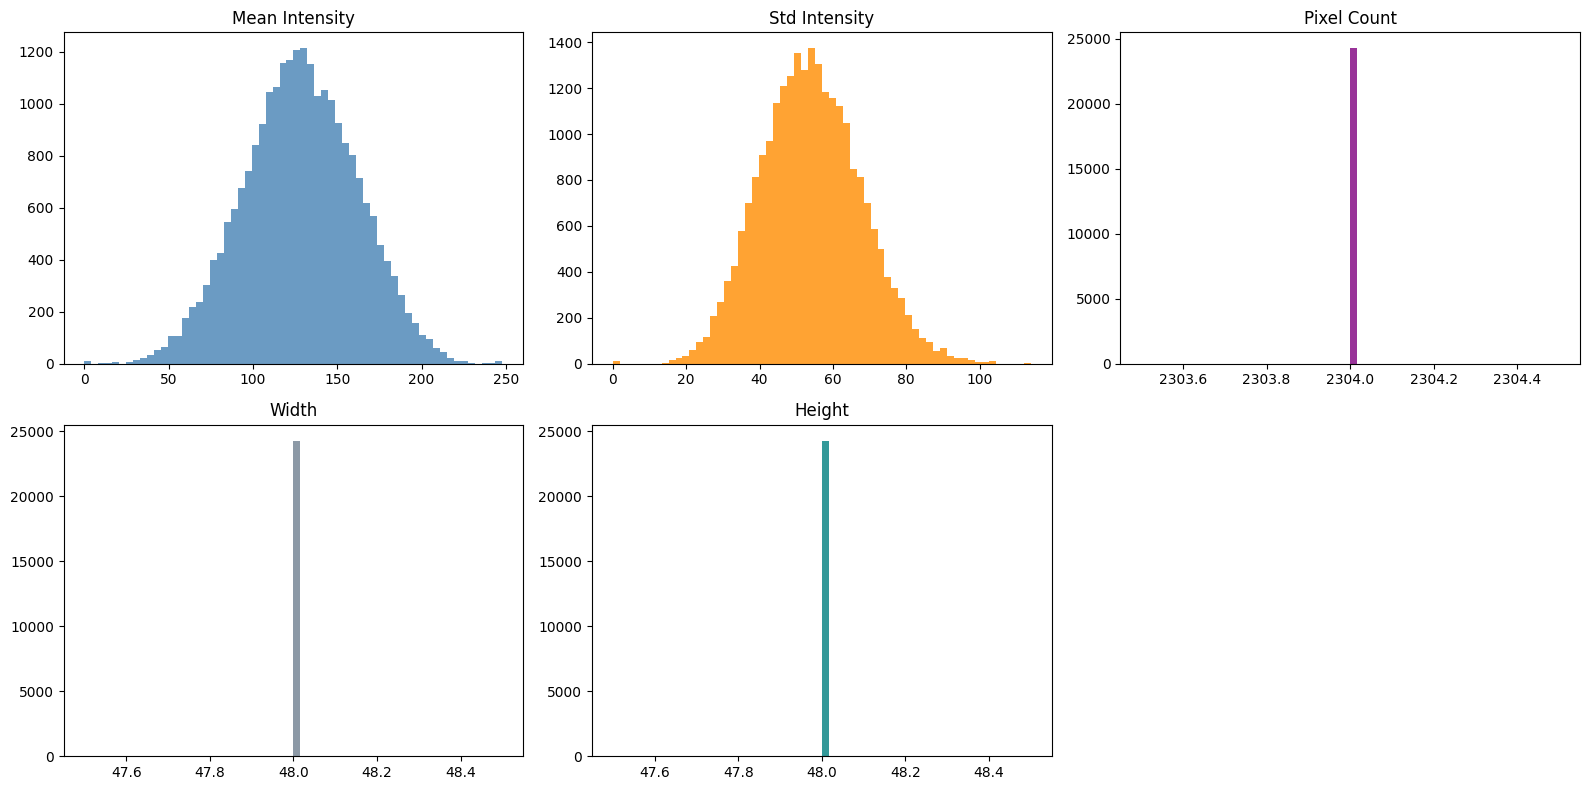

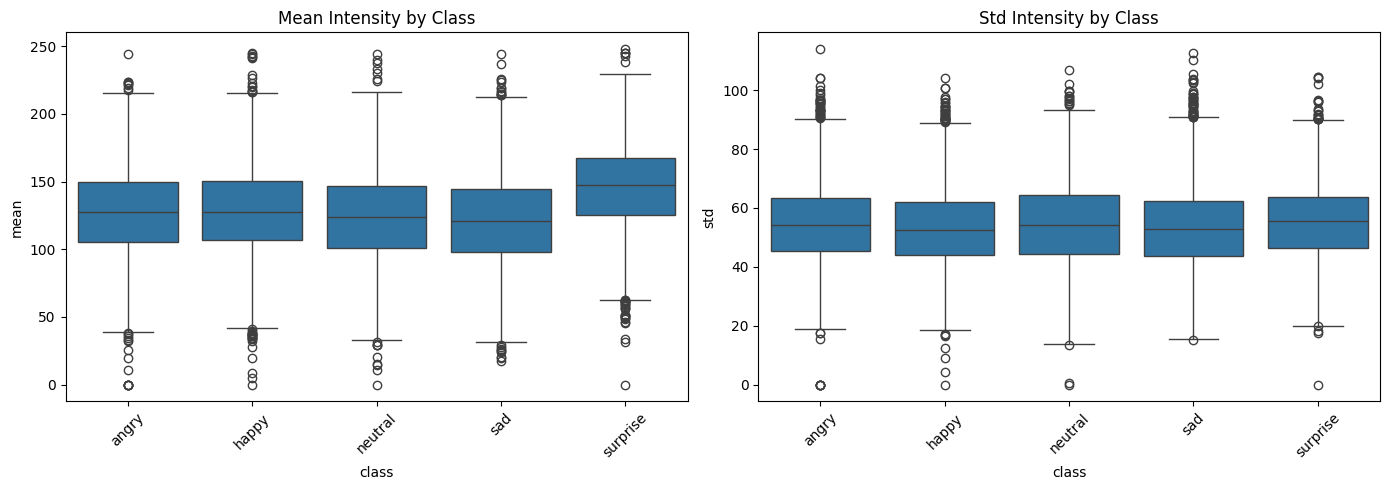

Done: distribution plots.


In [53]:
# Aggregations & visualizations
if 'stats_full_df' not in locals() or stats_full_df.empty:
    raise RuntimeError('Run previous cell to build stats_full_df')

agg_split = stats_full_df.groupby('split')[['mean','std','height','width','pixels']].agg(['mean','std','min','max'])
agg_class = stats_full_df.groupby('class')[['mean','std','height','width','pixels']].agg(['mean','std','min','max'])
agg_split_class = stats_full_df.groupby(['split','class'])[['mean','std','height','width','pixels']].mean()

print('Per-split summary:')
display(agg_split)
print('Per-class summary:')
display(agg_class)

fig, axes = plt.subplots(2,3, figsize=(16,8))
axes = axes.flatten()
axes[0].hist(stats_full_df['mean'], bins=60, color='steelblue', alpha=0.8); axes[0].set_title('Mean Intensity')
axes[1].hist(stats_full_df['std'], bins=60, color='darkorange', alpha=0.8); axes[1].set_title('Std Intensity')
axes[2].hist(stats_full_df['pixels'], bins=60, color='purple', alpha=0.8); axes[2].set_title('Pixel Count')
axes[3].hist(stats_full_df['width'], bins=60, color='slategray', alpha=0.8); axes[3].set_title('Width')
axes[4].hist(stats_full_df['height'], bins=60, color='teal', alpha=0.8); axes[4].set_title('Height')
axes[5].axis('off')
plt.tight_layout(); plt.show()

# Boxplots by class
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.boxplot(x='class', y='mean', data=stats_full_df, ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Mean Intensity by Class')
sns.boxplot(x='class', y='std', data=stats_full_df, ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Std Intensity by Class')
plt.tight_layout(); plt.show()

print('Done: distribution plots.')

Showing 6 samples


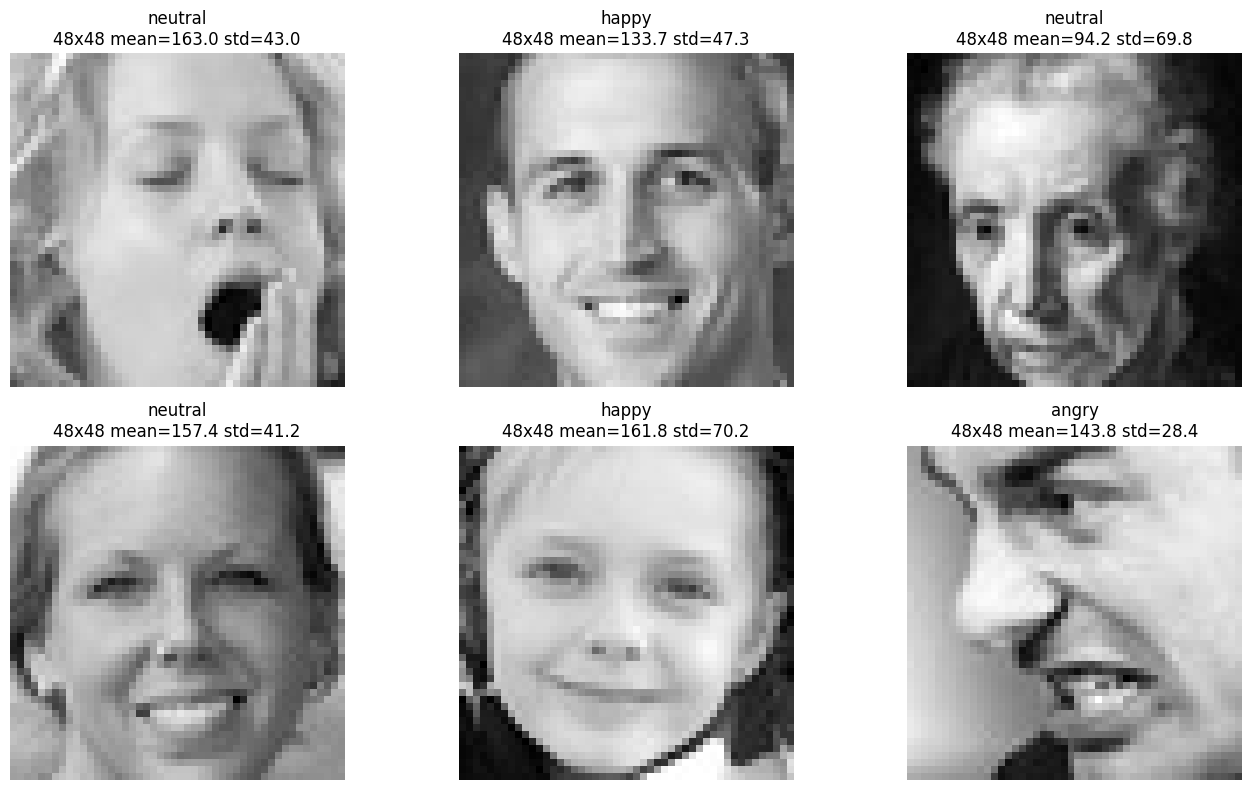

First sample filepath: /content/ann-visual-emotion/data/raw/EmoSet_backup_original_1757667648/train/neutral/27412.jpg
Shape: (48, 48)
Top-left 12x12 matrix slice:
 [[191 183 183 161 154 162 220 244 200 155 134 130]
 [182 181 172 170 168 178 231 236 152 136 130 138]
 [182 182 169 174 160 205 237 187 128 139 134 140]
 [192 190 173 167 169 218 216 167 146 140 126 138]
 [200 179 161 154 181 211 189 156 161 133 119 136]
 [190 164 145 166 181 195 167 157 167 134 124 136]
 [168 155 140 175 167 160 138 174 177 138 124 135]
 [181 160 159 167 147 146 143 167 178 149 129 131]
 [186 161 162 150 153 160 133 173 178 166 137 128]
 [190 165 160 137 191 155 155 182 175 167 152 144]
 [179 185 157 150 188 158 172 170 170 166 163 155]
 [182 189 137 169 197 180 160 146 165 168 167 162]]


In [54]:
# Sample image matrix inspection
SAMPLE_COUNT = 6
rand_samples = stats_full_df.sample(n=min(SAMPLE_COUNT, len(stats_full_df)), random_state=42)
print(f"Showing {len(rand_samples)} samples")

fig, axes = plt.subplots(2,3, figsize=(14,8))
axes = axes.flatten()
for ax, (_, row) in zip(axes, rand_samples.iterrows()):
    path = Path(row['filepath'])
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        ax.set_title('Load fail')
        ax.axis('off')
        continue
    if len(img.shape)==2:
        disp = img; cmap='gray'
    else:
        disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); cmap=None
    ax.imshow(disp, cmap=cmap)
    ax.set_title(f"{row['class']}\n{disp.shape[0]}x{disp.shape[1]} mean={row['mean']:.1f} std={row['std']:.1f}")
    ax.axis('off')
plt.tight_layout(); plt.show()

first_fp = rand_samples.iloc[0]['filepath']
raw_img = cv2.imread(first_fp, cv2.IMREAD_UNCHANGED)
print('First sample filepath:', first_fp)
print('Shape:', raw_img.shape)
print('Top-left 12x12 matrix slice:\n', raw_img[:12,:12])

In [57]:
# Calculate and print stats for the original 48x48 images
print('Original 48x48 Global Summary:')

post_stats = {
    'target_size': {'width': 48, 'height': 48},
    'num_images': int(len(stats_full_df)),
    'height_unique': sorted([int(x) for x in stats_full_df['height'].unique()]),
    'width_unique': sorted([int(x) for x in stats_full_df['width'].unique()]),
    'global_mean_mean': float(stats_full_df['mean'].mean()),
    'global_mean_std': float(stats_full_df['mean'].std()),
    'global_pixel_std_mean': float(stats_full_df['std'].mean()),
    'global_pixel_std_std': float(stats_full_df['std'].std()),
}

print(json.dumps(post_stats, indent=2))

print('\nStats calculation for 48x48 images complete.')

Original 48x48 Global Summary:
{
  "target_size": {
    "width": 48,
    "height": 48
  },
  "num_images": 24282,
  "height_unique": [
    48
  ],
  "width_unique": [
    48
  ],
  "global_mean_mean": 128.15308723372334,
  "global_mean_std": 33.58377534716462,
  "global_pixel_std_mean": 54.01617694523079,
  "global_pixel_std_std": 13.67115253331477
}

Stats calculation for 48x48 images complete.


In [ ]:
# In-place resizing (with backup) and updated stats
TARGET_RESIZE = (224, 224)  # (width, height)
BACKUP_ORIGINALS = True
BACKUP_DIR = RAW_EMOSET.parent / f"EmoSet_backup_original_{int(time.time())}"

from shutil import copy2, copytree

if BACKUP_ORIGINALS:
    if any(p.name.startswith('EmoSet_backup_original_') for p in RAW_EMOSET.parent.iterdir() if p.is_dir()):
        print('Backup already exists, skipping new backup.')
    else:
        print(f'Creating backup at {BACKUP_DIR} ...')
        copytree(RAW_EMOSET, BACKUP_DIR)
        print('Backup completed.')
else:
    print('Backup disabled (BACKUP_ORIGINALS=False)')

# Resize only if needed (skip if already target size)
updated = 0
skipped = 0
for _, row in stats_full_df.iterrows():
    fp = Path(row['filepath'])
    img = cv2.imread(str(fp), cv2.IMREAD_UNCHANGED)
    if img is None:
        continue
    h,w = img.shape[:2]
    if (w,h) == TARGET_RESIZE:
        skipped += 1
        continue
    # Normalize channels
    if len(img.shape)==2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, TARGET_RESIZE, interpolation=cv2.INTER_AREA)
    # Overwrite (convert back to BGR for cv2.imwrite)
    cv2.imwrite(str(fp), cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))
    updated += 1
print(f"Resizing done. Updated: {updated}, already target size: {skipped}")

# Recompute global stats after resize (sample if very large for speed)
re_stats = []
for _, row in stats_full_df.iterrows():
    fp = Path(row['filepath'])
    img = cv2.imread(str(fp), cv2.IMREAD_UNCHANGED)
    if img is None: continue
    h,w = img.shape[:2]
    if len(img.shape)==2:
        arr = img.astype(np.float32)
    else:
        arr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    re_stats.append([h,w,arr.mean(),arr.std()])
re_stats = np.array(re_stats)

post_stats = {
    'target_size': {'width': TARGET_RESIZE[0], 'height': TARGET_RESIZE[1]},
    'num_images': int(len(re_stats)),
    'height_unique': sorted(list(set(int(x) for x in re_stats[:,0]))),
    'width_unique': sorted(list(set(int(x) for x in re_stats[:,1]))),
    'global_mean_mean': float(re_stats[:,2].mean()),
    'global_mean_std': float(re_stats[:,2].std()),
    'global_pixel_std_mean': float(re_stats[:,3].mean()),
    'global_pixel_std_std': float(re_stats[:,3].std()),
}
print('Post-resize global summary:')
print(json.dumps(post_stats, indent=2))

# Save detailed per-image stats (resized) to JSON (may be large) & summary
RESIZE_STATS_JSON = RAW_EMOSET.parent / 'resize_stats.json'
GLOBAL_STATS_JSON = RAW_EMOSET.parent / 'global_pixel_stats.json'

# To limit size, only store aggregated means per class & split
agg_after = defaultdict(lambda: {'count':0,'mean_sum':0.0,'std_sum':0.0})
for _, r in stats_full_df.iterrows():
    agg_after[(r['split'], r['class'])]['count'] += 1

# Re-scan means after resize (single pass)
for key in agg_after.keys():
    split, cls = key
    # (Optional: could compute per-class means precisely again if needed)

with open(GLOBAL_STATS_JSON, 'w') as f:
    json.dump(post_stats, f, indent=2)
print(f'Saved global stats: {GLOBAL_STATS_JSON}')

# Update CSV train/val/test width/height columns if desired
for csv_path in [CSV_TRAIN, CSV_VAL, CSV_TEST]:
    if not csv_path.exists():
        continue
    df = pd.read_csv(csv_path)
    if 'width' not in df.columns:
        df['width'] = TARGET_RESIZE[0]
    else:
        df['width'] = TARGET_RESIZE[0]
    if 'height' not in df.columns:
        df['height'] = TARGET_RESIZE[1]
    else:
        df['height'] = TARGET_RESIZE[1]
    df.to_csv(csv_path, index=False)
    print(f'Updated dimensions in {csv_path.name}')

print('In-place resize + metadata update complete.')